## Data Loading

In [3]:
import numpy as np
import csv
from tqdm import tqdm

# load data
path = 'eedi_data/data/train_data/train_task_3_4.csv'
answer_data = np.loadtxt(path, delimiter = ',', dtype=int, skiprows = 1)
print('successfully loaded %d responses' % answer_data.shape[0])

# load metadata
path = 'eedi_data/data/metadata/answer_metadata_task_3_4.csv'
answer_metadata = {}
with open(path) as f:
    reader = csv.reader(f, delimiter=',')
    header = reader.__next__()
    for row in reader:
        answer_metadata[int(row[0])] = row[1:]
print('successfully loaded metadata for %d responses' % len(answer_metadata))

successfully loaded 1382727 responses
successfully loaded metadata for 1508917 responses


In [4]:
# re-format data into a student x responses matrix, where missing responses are signified as nan
# importantly, we treat students as new if they gave their answers on different days. This way,
# we account for the fact that knowledge may change over time

# number of questions
n = len(np.unique(answer_data[:, 0]))

# initialize dictionary mapping combinations of user-ids and days to rows of the response matrix
X_dict = {}
for l in tqdm(range(answer_data.shape[0])):
    j         = answer_data[l, 0]
    user_id   = answer_data[l, 1]
    answer_id = answer_data[l, 2]
    metadata  = answer_metadata[answer_id]
    day       = metadata[0][:10]
    row       = X_dict.setdefault(str(user_id) + '_' + day, np.full(n, np.nan))
    row[j]    = answer_data[l, 3]
# re-format to matrix
keys = sorted(X_dict.keys())
m = len(keys)
X = np.stack([X_dict[key] for key in sorted(X_dict.keys())], 0)
del X_dict

100%|██████████| 1382727/1382727 [00:09<00:00, 153416.37it/s]


In [5]:
print('on average %g answers per session' % np.mean(n - np.sum(np.isnan(X), 1)))
print('on average %g answers per question' % np.mean(m - np.sum(np.isnan(X), 0)))

on average 20.9273 answers per session
on average 1458.57 answers per question


In [6]:
# re-format the data into one response matrix per quiz, where rows are users
# and columns are items

# in a first step, aggregate the items for each quiz and the answers for each
# quiz in dictionaries
quiz_items   = {}
quiz_answers = {}

for l in tqdm(range(answer_data.shape[0])):
    # extract relevant answer data
    j         = answer_data[l, 0]
    user_id   = answer_data[l, 1]
    answer_id = answer_data[l, 2]
    y         = answer_data[l, 3]
    # extract relevant answer metadata
    metadata  = answer_metadata[answer_id]
    day       = metadata[0][:10]
    q         = int(metadata[3])
    # store it in new format
    qset      = quiz_items.setdefault(q, set())
    qset.add(j)
    qmap      = quiz_answers.setdefault(q, {})
    umap      = qmap.setdefault(str(user_id) + '_' + day, {})
    umap[j]   = y

# in a second step, reformat to matrices
X = {}
for q in sorted(quiz_items.keys()):
    quiz_items[q] = list(sorted(quiz_items[q]))
    qmap = quiz_answers[q]
    Xq = np.full((len(qmap), len(quiz_items[q])), np.nan)
    i = 0
    for key in sorted(qmap):
        for j in qmap[key]:
            j2 = quiz_items[q].index(j)
            Xq[i, j2] = qmap[key][j]
        i += 1
    X[q] = Xq

  0%|          | 0/1382727 [00:00<?, ?it/s]

100%|██████████| 1382727/1382727 [00:06<00:00, 197993.90it/s]


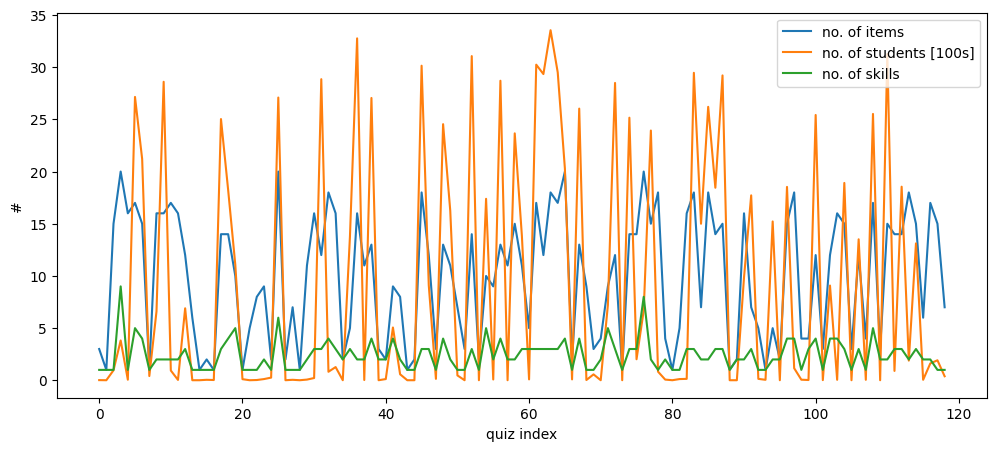

In [7]:
skill_map = {
    'basic algebra' : 0,
    'absolute value' : 0,
    'fractions' : 1,
    'factorization' : 2,
    'powers' : 3,
    'variable algebra' : 4,
    'rectangle' : 5,
    'triangle' : 6,
    'circle' : 7,
    'parallelogram' : 8,
    'quadrilateral' : 8,
    'lines and angles' : 9,
    'vectors' : 10,
    'symmetry' : 11,
    'alternative number systems' : 12,
    'time' : 13
}

Q = []

with open('eedi_q_matrix.csv') as f:
    reader = csv.reader(f, delimiter = '\t')
    reader.__next__()
    for line in reader:
        k = None
        for entry in line[1].split(', '):
            if entry in skill_map:
                k = skill_map[entry]
                break
        if k is None:
            raise ValueError('did not find any valid skill for item %s' % line[0])
        Q.append(k)
Q = np.array(Q, dtype=int)

num_items    = np.zeros(len(quiz_items), dtype=int)
num_students = np.zeros(len(quiz_items), dtype=int)
num_skills   = np.zeros(len(quiz_items), dtype=int)
for q in sorted(quiz_items.keys()):
    num_items[q]    = X[q].shape[1]
    num_students[q] = X[q].shape[0]
    skill_set       = set()
    for j in quiz_items[q]:
        skill_set.add(Q[j])
    num_skills[q] = len(skill_set)

metadata_labels = ['num_items', 'num_students', 'num_skills', 'frac_nans']

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(num_items[num_items < 100])
plt.plot(num_students[num_items < 100] / 100)
plt.plot(num_skills[num_items < 100])
plt.xlabel('quiz index')
plt.ylabel('#')
plt.legend(['no. of items', 'no. of students [100s]', 'no. of skills'])
plt.show()

In [8]:
# ensure that the quiz ids are just ascending indices so that we don't have to maintain an additional
# ID map
if np.sum(np.abs(np.arange(len(quiz_items)) - np.array(list(sorted(quiz_items.keys()))))) > 1E-3:
    raise ValueError('Quiz items were not indexed as expected')

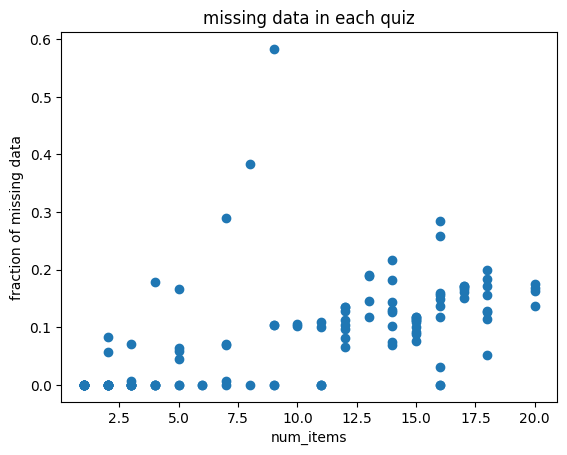

In [9]:
# check the nan avg for each quiz
nans = np.zeros(len(quiz_items))
for q in X:
    nans[q] = np.mean(np.isnan(X[q]))
import matplotlib.pyplot as plt
plt.scatter(num_items[num_items < 100], nans[num_items < 100])
plt.xlabel('num_items')
plt.ylabel('fraction of missing data')
plt.title('missing data in each quiz')
plt.show()

## Hyperparameter optimization

In [10]:
import sparfa
import vibo
import sparfae
import time
import os
from sklearn.model_selection import KFold
from sklearn import metrics

# set up experimental metadata
num_folds = 10
min_students = 50
num_hyper_quizzes = 10

# set up method labels and hyperparameters to be tested
method_labels = ['SPARFA', 'VIBO', 'QFactor', 'Q2Factor']
hyperparams     = [(1E-5, 1E-3, 1E-3), (1E-4, 5E-2,1E-3), (1E-3, 1., 1E-3), (1E-2, 5E-2, 5E-2), (1E-1, 1., 5E-2), (1., 1., 1.)]

# set up filter for quizzes
selection     = np.where(np.logical_and(num_items < 100, num_students >= min_students))[0]
num_quizzes   = len(selection)

# set up result tensors
hyper_test_aucs  = np.full((num_hyper_quizzes, len(method_labels), len(hyperparams), num_folds), np.nan)
hyper_times      = np.full((num_hyper_quizzes, len(method_labels), len(hyperparams), num_folds), np.nan)

# try to read (partial) hyperparam optimization results from file
hyper_results_file_name = 'eedi_q_learning_hypersearch_results.csv'
if os.path.isfile(hyper_results_file_name):
    datamat = np.loadtxt(hyper_results_file_name, delimiter = '\t', skiprows = 1)
    hyper_quizzes = datamat[:, 0].astype(int)
    experiment_quizzes = np.setdiff1d(selection, hyper_quizzes)
    # override result tensor entries with partial results (if available)
    col = len(metadata_labels) + 1
    for method in range(len(method_labels)):
        for par in range(len(hyperparams)):
            hyper_test_aucs[:, method, par, :] = np.expand_dims(datamat[:, col], 1)
            hyper_times[:, method, par, :]     = np.expand_dims(datamat[:, col+1], 1)
            col += 2
else:
    # sample a random subset of quizzes for hyperparameter optimization
    quiz_shuffle  = np.random.permutation(num_quizzes)
    hyper_quizzes = selection[quiz_shuffle[:num_hyper_quizzes]]
    experiment_quizzes = selection[quiz_shuffle[num_hyper_quizzes:]]

# set up evaluation function
def evaluate(Xtrue, Ppred):
    # flatten and remove nans
    xtrue = np.ravel(Xtrue)
    nonnans = np.logical_not(np.isnan(xtrue))
    ppred = np.ravel(Ppred)
    xtrue = xtrue[nonnans]
    ppred = ppred[nonnans]
    # compute accuracy
    acc   = 1. - np.mean(np.abs(xtrue - np.round(ppred)))
    # compute AUC
    pos_label = 1.
    fpr, tpr, _ = metrics.roc_curve(xtrue, ppred, pos_label=pos_label)
    auc   = metrics.auc(fpr, tpr)
    return acc, auc

# start iterating over quizzes
for q2 in range(num_hyper_quizzes):
    q = hyper_quizzes[q2]
    print('\n--- quiz %d of %d (%d students, %d items) ---\n' % (q2+1, num_hyper_quizzes, num_students[q], num_items[q]))
    # retrieve X for current quiz
    Xq = X[q]
    m  = Xq.shape[0]
    # retrieve number of concepts for current quiz
    # We take the number of manually defined skills but upper-bound it
    # by half the number of items
    num_concepts = min(Xq.shape[1] // 2, num_skills[q])
    # set up crossvalidation folds
    folds = KFold(n_splits=num_folds, random_state=None, shuffle=False)
    # iterate over folds
    f = 0
    for train_index, test_index in folds.split(Xq):
        print('-- fold %d of %d ---' % (f+1, num_folds))
        # iterate over hyperparameters
        for par in tqdm(range(len(hyperparams))):
            vae_regul, l1regul, l2regul = hyperparams[par]
            # iterate over models
            for method in range(len(method_labels)):
                if not np.isnan(hyper_test_aucs[q2, method, par, f]):
                    continue
                # set up the model
                start = time.time()
                if method_labels[method] == 'SPARFA':
                    model = sparfa.SPARFA(num_concepts, l1regul = l1regul, l2regul = l2regul)
                elif method_labels[method] == 'VIBO':
                    model = vibo.VIBO(Xq.shape[1], num_concepts, num_epochs = 100, lr = 5E-3, minibatch_size = 16, regul = vae_regul)
                elif method_labels[method] == 'QFactor':
                    model = sparfae.QFactorModel(num_concepts, l1regul = l1regul, l2regul = l2regul)
                elif method_labels[method] == 'Q2Factor':
                    model = sparfae.QTwoFactorModel(num_concepts, l1regul = l1regul, l2regul = l2regul)
                else:
                    raise ValueError('unknown method')
                # train the model
                model.fit(Xq[train_index, :])
                # predict on test data
                P = model.predict_proba(Xq[test_index, :])
                # compute test AUC
                _, hyper_test_aucs[q2, method, par, f] = evaluate(Xq[test_index, :], P)
                # compute time
                hyper_times[q2, method, par, f] = time.time() - start

        f += 1


--- quiz 1 of 10 (2393 students, 15 items) ---

-- fold 1 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 65196.44it/s]


-- fold 2 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 56299.38it/s]


-- fold 3 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 57852.47it/s]


-- fold 4 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 59918.63it/s]


-- fold 5 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 82241.25it/s]


-- fold 6 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 79638.68it/s]


-- fold 7 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 83330.54it/s]


-- fold 8 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 86778.70it/s]


-- fold 9 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 84449.07it/s]


-- fold 10 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 83330.54it/s]



--- quiz 2 of 10 (2120 students, 15 items) ---

-- fold 1 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 83330.54it/s]


-- fold 2 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 84166.64it/s]


-- fold 3 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 85019.68it/s]


-- fold 4 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 82241.25it/s]


-- fold 5 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 84733.41it/s]


-- fold 6 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 85307.88it/s]


-- fold 7 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 41459.35it/s]


-- fold 8 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44073.25it/s]


-- fold 9 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 32682.89it/s]


-- fold 10 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44779.05it/s]



--- quiz 3 of 10 (2603 students, 13 items) ---

-- fold 1 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44073.25it/s]


-- fold 2 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 32853.56it/s]


-- fold 3 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 43919.41it/s]


-- fold 4 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44384.17it/s]


-- fold 5 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 33644.15it/s]


-- fold 6 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 24576.00it/s]


-- fold 7 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 31775.03it/s]


-- fold 8 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44228.16it/s]


-- fold 9 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 29330.80it/s]


-- fold 10 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44228.16it/s]



--- quiz 4 of 10 (506 students, 9 items) ---

-- fold 1 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 43464.29it/s]


-- fold 2 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 31418.01it/s]


-- fold 3 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 38896.17it/s]


-- fold 4 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 41459.35it/s]


-- fold 5 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 32725.39it/s]


-- fold 6 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 37617.08it/s]


-- fold 7 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44306.03it/s]


-- fold 8 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 43842.90it/s]


-- fold 9 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 27206.30it/s]


-- fold 10 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 41527.76it/s]



--- quiz 5 of 10 (57 students, 3 items) ---

-- fold 1 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 42871.93it/s]


-- fold 2 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44620.26it/s]


-- fold 3 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44858.87it/s]


-- fold 4 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44228.16it/s]


-- fold 5 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44699.51it/s]


-- fold 6 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 45262.27it/s]


-- fold 7 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 43919.41it/s]


-- fold 8 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 45019.36it/s]


-- fold 9 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 45262.27it/s]


-- fold 10 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 45019.36it/s]



--- quiz 6 of 10 (2366 students, 15 items) ---

-- fold 1 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 42726.36it/s]


-- fold 2 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 33244.15it/s]


-- fold 3 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44779.05it/s]


-- fold 4 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 30765.07it/s]


-- fold 5 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 32982.73it/s]


-- fold 6 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 33244.15it/s]


-- fold 7 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44938.97it/s]


-- fold 8 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44779.05it/s]


-- fold 9 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 32640.50it/s]


-- fold 10 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44620.26it/s]



--- quiz 7 of 10 (2709 students, 20 items) ---

-- fold 1 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44384.17it/s]


-- fold 2 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 32896.50it/s]


-- fold 3 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44620.26it/s]


-- fold 4 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44779.05it/s]


-- fold 5 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 33332.22it/s]


-- fold 6 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 45019.36it/s]


-- fold 7 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44306.03it/s]


-- fold 8 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 32982.73it/s]


-- fold 9 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 32388.45it/s]


-- fold 10 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 45262.27it/s]



--- quiz 8 of 10 (1739 students, 10 items) ---

-- fold 1 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44620.26it/s]


-- fold 2 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44620.26it/s]


-- fold 3 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 31936.32it/s]


-- fold 4 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 33069.41it/s]


-- fold 5 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 45100.04it/s]


-- fold 6 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 33156.55it/s]


-- fold 7 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44938.97it/s]


-- fold 8 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 33376.42it/s]


-- fold 9 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44462.59it/s]


-- fold 10 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44541.28it/s]


--- quiz 9 of 10 (83 students, 18 items) ---

-- fold 1 of 10 ---



100%|██████████| 6/6 [00:00<00:00, 44462.59it/s]


-- fold 2 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44462.59it/s]


-- fold 3 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44384.17it/s]


-- fold 4 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44541.28it/s]


-- fold 5 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44073.25it/s]


-- fold 6 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44858.87it/s]


-- fold 7 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44462.59it/s]


-- fold 8 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44779.05it/s]


-- fold 9 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 45019.36it/s]


-- fold 10 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 41943.04it/s]



--- quiz 10 of 10 (2620 students, 18 items) ---

-- fold 1 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 43996.20it/s]


-- fold 2 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 32768.00it/s]


-- fold 3 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 43766.65it/s]


-- fold 4 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 33069.41it/s]


-- fold 5 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 33156.55it/s]


-- fold 6 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 43766.65it/s]


-- fold 7 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 32768.00it/s]


-- fold 8 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 44306.03it/s]


-- fold 9 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 32939.56it/s]


-- fold 10 of 10 ---


100%|██████████| 6/6 [00:00<00:00, 33420.75it/s]


In [11]:
# store hyperparameter results
metadata = [num_items[hyper_quizzes], num_students[hyper_quizzes], num_skills[hyper_quizzes], nans[hyper_quizzes]]
datamat = [hyper_quizzes] + metadata
headers = ['quiz_id'] + metadata_labels
for method in range(len(method_labels)):
    for par in range(len(hyperparams)):
        vae_regul, l1regul, l2regul = hyperparams[par]
        if method_labels[method] == 'VIBO':
            method_str = '%s_%g' % (method_labels[method], vae_regul)
        else:
            method_str = '%s_l1_%g_l2_%g' % (method_labels[method], l1regul, l2regul)
        # AUCs
        datamat.append(np.mean(hyper_test_aucs[:, method, par, :], 1))
        headers.append('%s_auc_mean' % method_str)
        # times
        datamat.append(np.mean(hyper_times[:, method, par, :], 1))
        headers.append('%s_time' % method_str)
datamat = np.stack(datamat, 1)
np.savetxt(hyper_results_file_name, datamat, delimiter = '\t', fmt = '%g', header = '\t'.join(headers), comments = '')

In [12]:
# select optimal hyperparameters for each method
hyper_test_mean_aucs = np.mean(np.mean(hyper_test_aucs, 3), 0)
par_opts = np.argmax(hyper_test_mean_aucs, 1)
for method in range(len(method_labels)):
    par = par_opts[method]
    vae_regul, l1regul, l2regul = hyperparams[par]
    if method_labels[method] == 'VIBO':
        print('optimal regularization strength for VIBO: %g (AUC: %g)' % (vae_regul, hyper_test_mean_aucs[method, par]))
    else:
        print('optimal regularization strengths for %s: l1: %g, l2: %g (AUC: %g)' % (method_labels[method], l1regul, l2regul, hyper_test_mean_aucs[method, par]))

optimal regularization strengths for SPARFA: l1: 0.05, l2: 0.001 (AUC: 0.924559)
optimal regularization strength for VIBO: 0.001 (AUC: 0.899466)
optimal regularization strengths for QFactor: l1: 0.05, l2: 0.05 (AUC: 0.897546)
optimal regularization strengths for Q2Factor: l1: 0.05, l2: 0.001 (AUC: 0.909194)


In [13]:
# show data hyperparameters for selected quizzes
print('%d quizzes left with at least %d students' % (len(selection), min_students))
print('on avg. %g items per quiz' % np.mean(num_items[selection]))
print('on avg. %g students per quiz' % np.mean(num_students[selection]))
print('on avg. %g skills per quiz' % np.mean(num_skills[selection]))

65 quizzes left with at least 50 students
on avg. 14.0154 items per quiz
on avg. 1675.06 students per quiz
on avg. 3.21538 skills per quiz


## Actual Experiment

In [14]:
# set up result tensors
train_accs     = np.full((len(experiment_quizzes), len(method_labels), num_folds), np.nan)
train_aucs     = np.full((len(experiment_quizzes), len(method_labels), num_folds), np.nan)
test_accs      = np.full((len(experiment_quizzes), len(method_labels), num_folds), np.nan)
test_aucs      = np.full((len(experiment_quizzes), len(method_labels), num_folds), np.nan)
sparsity       = np.full((len(experiment_quizzes), len(method_labels), num_folds), np.nan)
train_times    = np.full((len(experiment_quizzes), len(method_labels), num_folds), np.nan)
predict_times  = np.full((len(experiment_quizzes), len(method_labels), num_folds), np.nan)

results_labels = ['train_acc', 'train_auc', 'test_acc', 'test_auc', 'sparsity', 'train_time', 'pred_time']
results_list   = [train_accs, train_aucs, test_accs, test_aucs, sparsity, train_times, predict_times]

intermediate_results_header  = []
for res in range(len(results_labels)):
    for method in range(len(method_labels)):
        intermediate_results_header.append('%s_%s' % (method_labels[method], results_labels[res]))

# start iterating over quizzes
for q2 in tqdm(range(len(experiment_quizzes))):
    q = experiment_quizzes[q2]
    # try to load intermediate results for this quiz
    intermediate_results_file = 'eedi_intermediate_results/%d_results.csv' % q
    if os.path.isfile(intermediate_results_file):
        datamat = np.loadtxt(intermediate_results_file, delimiter = '\t', skiprows = 1)
        for res in range(len(results_labels)):
            results_list[res][q2, :, :] = datamat[:, res*len(method_labels):(res+1)*len(method_labels)].T
    # retrieve X for current quiz
    Xq = X[q]
    m  = Xq.shape[0]
    # retrieve number of concepts for current quiz
    # We take the number of manually defined skills but upper-bound it
    # by half the number of items
    num_concepts = min(Xq.shape[1] // 2, num_skills[q])
    # set up crossvalidation folds
    folds = KFold(n_splits=num_folds, random_state=None, shuffle=False)
    # iterate over folds
    f = 0
    for train_index, test_index in folds.split(Xq):
        if not np.any(np.isnan(train_accs[q2, :, f])):
            f += 1
            continue
        # iterate over models
        for method in range(len(method_labels)):
            if not np.isnan(train_accs[q2, method, f]):
                continue
            # retrieve optimal hyperparameters for the current method
            par = par_opts[method]
            vae_regul, l1regul, l2regul = hyperparams[par]
            # set up the model
            start = time.time()
            if method_labels[method] == 'SPARFA':
                model = sparfa.SPARFA(num_concepts, l1regul = l1regul, l2regul = l2regul)
            elif method_labels[method] == 'VIBO':
                model = vibo.VIBO(Xq.shape[1], num_concepts, num_epochs = 100, lr = 5E-3, minibatch_size = 16, regul = vae_regul)
            elif method_labels[method] == 'QFactor':
                model = sparfae.QFactorModel(num_concepts, l1regul = l1regul, l2regul = l2regul)
            elif method_labels[method] == 'Q2Factor':
                model = sparfae.QTwoFactorModel(num_concepts, l1regul = l1regul, l2regul = l2regul)
            else:
                raise ValueError('unknown method')
            # train the model
            model.fit(Xq[train_index, :])
            # record training time
            train_times[q2, method, f] = time.time() - start
            # record sparsity
            sparsity[q2, method, f] = np.mean(np.abs(model.Q()) < 1E-3)
            # predict on train data
            P = model.predict_proba(Xq[train_index, :])
            # compute train accuracy and AUC
            train_accs[q2, method, f], train_aucs[q2, method, f] = evaluate(Xq[train_index, :], P)
            # predict on test data
            start = time.time()
            P = model.predict_proba(Xq[test_index, :])
            predict_times[q2, method, f] = time.time() - start
            # compute test accuracy and AUC
            test_accs[q2, method, f], test_aucs[q2, method, f] = evaluate(Xq[test_index, :], P)
        # store intermediate results
        datamat = np.concatenate([resmat[q2, :, :].T for resmat in results_list], 1)
        np.savetxt(intermediate_results_file, datamat, delimiter = '\t', fmt = '%g', header = '\t'.join(intermediate_results_header), comments = '')

        f += 1

100%|██████████| 55/55 [00:00<00:00, 1532.07it/s]


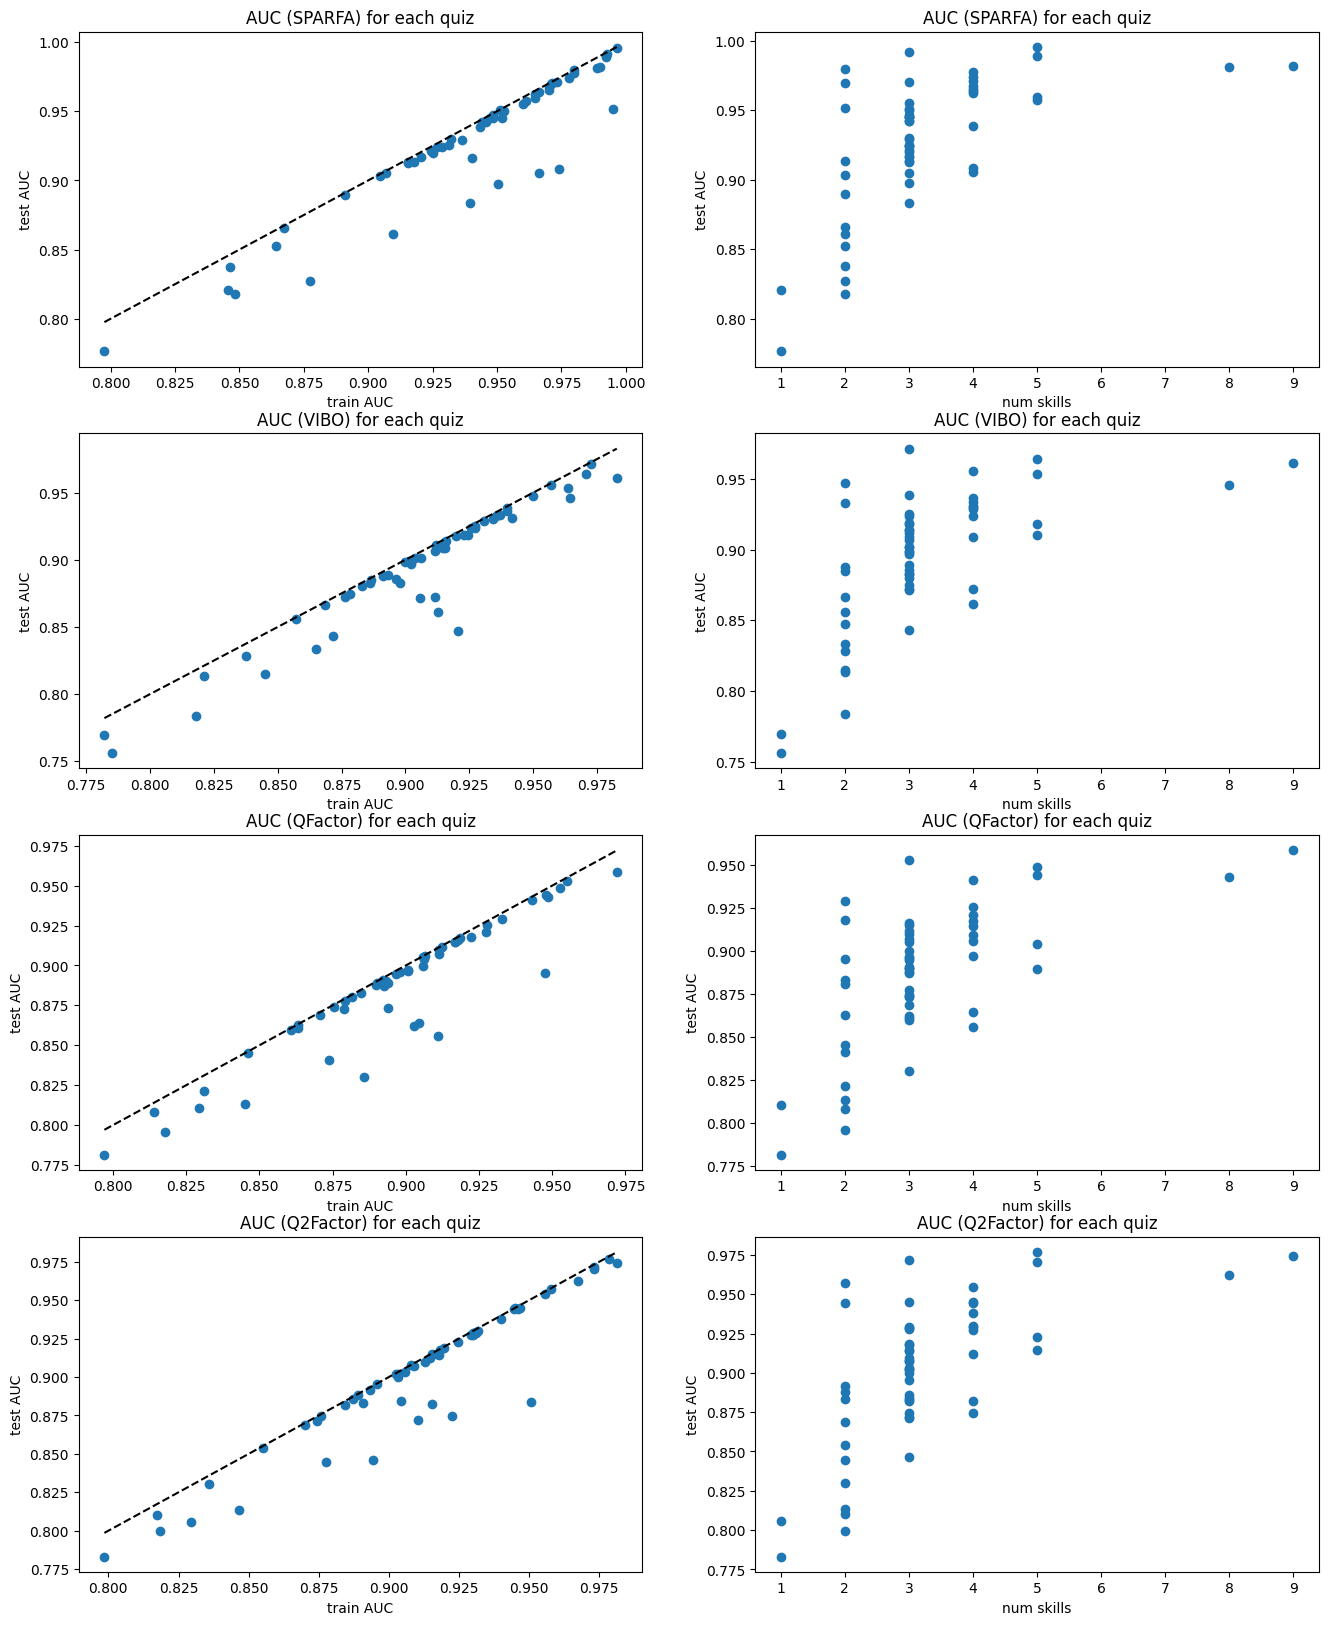

In [15]:
plt.figure(figsize=(16, 20))
for method in range(len(method_labels)):
    plt.subplot(len(method_labels), 2, 2*method + 1)
    plt.scatter(np.mean(train_aucs[:, method, :], 1), np.mean(test_aucs[:, method, :], 1))
    lo = np.min(np.mean(train_aucs[:, method, :], 1))
    hi = np.max(np.mean(train_aucs[:, method, :], 1))
    plt.plot([lo, hi], [lo, hi], 'k--')
    plt.xlabel('train AUC')
    plt.ylabel('test AUC')
    plt.title('AUC (%s) for each quiz' % method_labels[method])
    plt.subplot(len(method_labels), 2, 2*method + 2)
    plt.scatter(num_skills[experiment_quizzes], np.mean(test_aucs[:, method, :], 1))
    plt.xlabel('num skills')
    plt.ylabel('test AUC')
    plt.title('AUC (%s) for each quiz' % method_labels[method])
plt.show()

In [16]:
print('avg. test AUC +- std')
for method in range(len(method_labels)):
    print('%s: %g +- %g' % (method_labels[method], np.mean(test_aucs[:, method, :]), np.std(test_aucs[:, method, :])))
print('\navg. sparsity +- std')
for method in range(len(method_labels)):
    print('%s: %g +- %g' % (method_labels[method], np.mean(sparsity[:, method, :]), np.std(sparsity[:, method, :])))
print('\navg. train times +- std')
for method in range(len(method_labels)):
    print('%s: %g +- %g' % (method_labels[method], np.mean(train_times[:, method, :]), np.std(train_times[:, method, :])))
print('\navg. predict times +- std')
for method in range(len(method_labels)):
    print('%s: %g +- %g' % (method_labels[method], np.mean(predict_times[:, method, :]), np.std(predict_times[:, method, :])))

avg. test AUC +- std
SPARFA: 0.926722 +- 0.0519257
VIBO: 0.89427 +- 0.050896
QFactor: 0.886388 +- 0.0436834
Q2Factor: 0.900457 +- 0.0493494

avg. sparsity +- std
SPARFA: 0.158825 +- 0.0696476
VIBO: 0.00115653 +- 0.00738616
QFactor: 0.456529 +- 0.132374
Q2Factor: 0.32973 +- 0.110848

avg. train times +- std
SPARFA: 30.9538 +- 21.2269
VIBO: 7.83303 +- 5.21279
QFactor: 1.94359 +- 1.94674
Q2Factor: 15.7258 +- 18.8404

avg. predict times +- std
SPARFA: 0.633955 +- 0.458248
VIBO: 0.000313303 +- 0.000502246
QFactor: 0.000188432 +- 0.000353627
Q2Factor: 0.000200862 +- 0.000361481


In [17]:
# find out which approach has higher AUC overall
from scipy.stats import wilcoxon
reference = 0
for method in range(len(method_labels)):
    if method == reference:
        continue
    _, p = wilcoxon(np.mean(test_aucs[:, method, :], 1), np.mean(test_aucs[:, reference, :], 1), alternative = 'less')
    print('%s has higher AUC than %s: p = %g' % (method_labels[method], method_labels[reference], p))
    #_, p = wilcoxon(test_aucs[selection, method, :].ravel(), test_aucs[selection, reference, :].ravel(), alternative = 'less')
    #print('%s has higher AUC than %s: p = %g (raveled)' % (method_labels[method], method_labels[reference], p))

VIBO has higher AUC than SPARFA: p = 5.53808e-11
QFactor has higher AUC than SPARFA: p = 5.85274e-11
Q2Factor has higher AUC than SPARFA: p = 5.85274e-11


In [18]:
# try to find explanations for AUC differences between quizzes
# by correlating AUC with metadata
metadata = [num_items[experiment_quizzes], num_students[experiment_quizzes], num_skills[experiment_quizzes], nans[experiment_quizzes]]
metadata_labels = ['num_items', 'num_students', 'num_skills', 'frac_nans']

from scipy.stats import pearsonr
from scipy.stats import spearmanr

for method in range(len(method_labels)):
    print('\n%s test AUC correlates with:' % method_labels[method])
    for meta in range(len(metadata)):
        r1, p1 = pearsonr(np.mean(test_aucs[:, method, :], 1), metadata[meta])
        r2, p2 = spearmanr(np.mean(test_aucs[:, method, :], 1), metadata[meta])
        print('%s: r = %.2f (p = %.4f) / r = %.2f (p = %.4f)' % (metadata_labels[meta], r1, p1, r2, p2))


SPARFA test AUC correlates with:
num_items: r = -0.44 (p = 0.0008) / r = -0.51 (p = 0.0001)
num_students: r = 0.31 (p = 0.0199) / r = 0.14 (p = 0.2969)
num_skills: r = 0.61 (p = 0.0000) / r = 0.65 (p = 0.0000)
frac_nans: r = 0.04 (p = 0.7763) / r = -0.04 (p = 0.7970)

VIBO test AUC correlates with:
num_items: r = -0.38 (p = 0.0048) / r = -0.45 (p = 0.0005)
num_students: r = 0.40 (p = 0.0025) / r = 0.28 (p = 0.0388)
num_skills: r = 0.61 (p = 0.0000) / r = 0.64 (p = 0.0000)
frac_nans: r = -0.07 (p = 0.6322) / r = -0.07 (p = 0.6261)

QFactor test AUC correlates with:
num_items: r = -0.39 (p = 0.0033) / r = -0.46 (p = 0.0004)
num_students: r = 0.32 (p = 0.0167) / r = 0.22 (p = 0.1066)
num_skills: r = 0.62 (p = 0.0000) / r = 0.59 (p = 0.0000)
frac_nans: r = 0.03 (p = 0.8257) / r = -0.03 (p = 0.8221)

Q2Factor test AUC correlates with:
num_items: r = -0.41 (p = 0.0020) / r = -0.45 (p = 0.0005)
num_students: r = 0.32 (p = 0.0174) / r = 0.23 (p = 0.0905)
num_skills: r = 0.63 (p = 0.0000) / r 

In [19]:
# record results
results_file_name = 'eedi_q_learning_results.csv'
datamat = [experiment_quizzes] + metadata
headers = ['quiz_id'] + metadata_labels
for res in range(len(results_labels)):
    for method in range(len(method_labels)):
        headers.append('%s_%s_mean' % (method_labels[method], results_labels[res]))
        datamat.append(np.mean(results_list[res][:, method, :], 1))
        headers.append('%s_%s_std' % (method_labels[method], results_labels[res]))
        datamat.append(np.std(results_list[res][:, method, :], 1))
datamat = np.stack(datamat, 1)
np.savetxt(results_file_name, datamat, delimiter = '\t', fmt = '%g', header = '\t'.join(headers), comments = '')